In [1]:
from res.sequential_tasks import TemporalOrderExp6aSequence as QRSU

In [2]:
# Create a data generator
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

In [3]:
example_batch = example_generator[1]

In [4]:
example_batch[0].shape

(32, 9, 8)

In [5]:
example_batch[1].shape

(32, 4)

In [6]:
example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [0. 1. 0. 0.]


In [7]:
# First raw element
print('First raw element of 1st batch:\n {}'.format(example_batch[0][0]))
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

First raw element of 1st batch:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The sequence is: BXccYaaE
The class label is: R


In [8]:
# Second raw element
print('First raw element of 1st batch:\n {}'.format(example_batch[0][1]))
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][1])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][1])
print(f'The class label is: {class_label_decoded}')

First raw element of 1st batch:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The sequence is: BdXdXbE
The class label is: Q


### 2. Defining the Model

In [9]:
import tensorflow as tf
class SimpleRNN(tf.keras.Model):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        
        self.rnn = tf.keras.layers.SimpleRNN(units = hidden_size, 
                activation='relu', input_dim = input_size, 
                        return_state = True, return_sequences=True)
        self.linear = tf.keras.layers.Dense(units = output_size, 
                                            input_dim = hidden_size)
        
    def call(self, x):
        x = tf.cast(x, dtype=tf.float32)
        seq_h, o = self.rnn(x)
        # Should use 'o' instead of 'seq_h'
        x = self.linear(seq_h)
        return x
    
class SimpleLSTM(tf.keras.Model):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.lstm = tf.keras.layers.LSTM(units = hidden_size, 
                input_dim = input_size, return_sequences = True,
                                        return_state = True)
        self.linear = tf.keras.layers.Dense(units = output_size, 
                            input_dim = hidden_size)
        
    def call(self, x):
        x = tf.cast(x, dtype=tf.float32)
        seq_h, h, c = self.lstm(x)
        x = self.linear(seq_h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        for t in range(x.shape[1]):
            seq_h, h, c = self.lstm(x[:, t, :][:, tf.newaxis, :], 
                                    initial_state = h_c)
            h_list.append(h[:, tf.newaxis, :])
            c_list.append(c[:, tf.newaxis, :])
        h = tf.concat(h_list, axis=1)
        c = tf.concat(c_list, axis=1)
        return h, c

### 3. Defining the training loop

In [10]:
def train(model, train_data_gen, criterion, optimizer):
    num_correct = 0
    
    for batch_idx in range(len(train_data_gen)):
        data, target = train_data_gen[batch_idx]
        
        with tf.GradientTape() as tape:
            output = model(data)
            output = output[:, -1, :]
            
            loss = criterion(target, output)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        #print(output)
        #print(target)
        #break
        y_pred = tf.math.argmax(output, axis=1)
        target = tf.math.argmax(target, axis=1)
        #print(y_pred)
        corrects = tf.reduce_sum(tf.cast(y_pred == target, tf.int32))
        num_correct += corrects.numpy()
        
    return num_correct, loss
            

In [11]:
def test(model, test_data_gen, criterion):
    num_correct = 0
    
    for batch_idx in range(len(test_data_gen)):
        data, target = test_data_gen[batch_idx]
        output = model(data)
        output = output[:, -1, :]
        
        loss = criterion(output, target)
        
        y_pred = tf.math.argmax(output, axis=1)
        target = tf.math.argmax(target, axis=1)
        
        corrects = tf.reduce_sum(tf.cast(y_pred == target, tf.int32))
        num_correct += corrects.numpy()
        
    return num_correct, loss

### 4. Putting it together

In [12]:
import matplotlib.pyplot as plt
from res.plot_lib import set_default, plot_state, print_colourbar

In [13]:
set_default()

In [14]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer,
                  max_epochs, verbose=True):
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}
    
    for epoch in range(max_epochs):
        num_correct, loss = train(model, train_data_gen, 
                                  criterion, optimizer)
        accuracy = float(num_correct) / (len(train_data_gen) * \
                                         train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)
        
        num_correct, loss = train(model, test_data_gen, 
                                  criterion, optimizer)
        accuracy = float(num_correct) / (len(test_data_gen) * \
                                         test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)
        
        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: "
                  f"{history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, "
                  f"test_acc: {history_test['acc'][-1]:2.2f}%")
        
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    return model
        

### 5. Simple RNN: 10 epochs

[Epoch 1/10] loss: 1.4449, acc: 22.78% - test_loss: 1.3994, test_acc: 28.83%
[Epoch 2/10] loss: 1.4456, acc: 27.72% - test_loss: 1.3991, test_acc: 26.61%
[Epoch 3/10] loss: 1.3741, acc: 27.32% - test_loss: 1.3839, test_acc: 26.01%
[Epoch 4/10] loss: 1.3505, acc: 26.92% - test_loss: 1.3780, test_acc: 25.71%
[Epoch 5/10] loss: 1.3615, acc: 26.61% - test_loss: 1.3816, test_acc: 31.85%
[Epoch 6/10] loss: 1.4096, acc: 32.76% - test_loss: 1.3680, test_acc: 32.26%
[Epoch 7/10] loss: 1.3808, acc: 36.79% - test_loss: 1.2489, test_acc: 40.32%
[Epoch 8/10] loss: 1.1889, acc: 46.88% - test_loss: 1.2000, test_acc: 51.61%
[Epoch 9/10] loss: 1.0297, acc: 53.73% - test_loss: 0.9836, test_acc: 56.05%
[Epoch 10/10] loss: 0.9889, acc: 56.75% - test_loss: 0.8076, test_acc: 58.87%


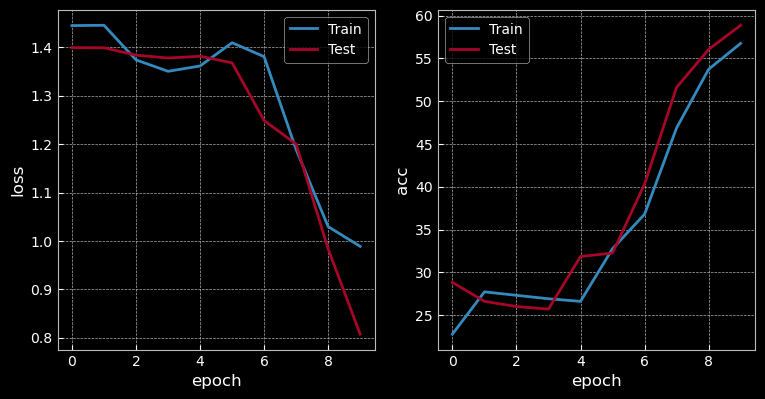

In [15]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
max_epochs = 10

model = train_and_test(model, train_data_gen, test_data_gen, criterion,
                      optimizer, max_epochs)

In [98]:
for parameter_group in model.trainable_variables:
    print(parameter_group.shape)

(8, 4)
(4, 4)
(4,)
(4, 4)
(4,)


### 6. Simple LSTM: 10 epochs

[Epoch 1/10] loss: 1.3521, acc: 29.74% - test_loss: 1.3882, test_acc: 27.92%
[Epoch 2/10] loss: 1.3791, acc: 28.53% - test_loss: 1.3311, test_acc: 36.49%
[Epoch 3/10] loss: 1.3411, acc: 50.10% - test_loss: 1.2866, test_acc: 57.86%
[Epoch 4/10] loss: 1.2636, acc: 59.88% - test_loss: 1.1638, test_acc: 63.00%
[Epoch 5/10] loss: 1.0500, acc: 59.58% - test_loss: 0.9329, test_acc: 61.49%
[Epoch 6/10] loss: 0.9103, acc: 65.83% - test_loss: 0.7755, test_acc: 78.83%
[Epoch 7/10] loss: 0.7599, acc: 94.35% - test_loss: 0.6463, test_acc: 99.19%
[Epoch 8/10] loss: 0.5772, acc: 99.90% - test_loss: 0.5156, test_acc: 100.00%
[Epoch 9/10] loss: 0.4253, acc: 100.00% - test_loss: 0.3537, test_acc: 100.00%
[Epoch 10/10] loss: 0.3505, acc: 100.00% - test_loss: 0.2956, test_acc: 100.00%


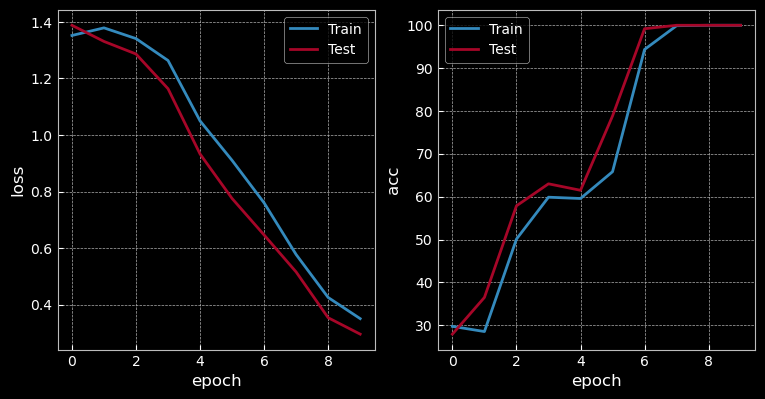

In [102]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer   = tf.keras.optimizers.Adam()
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, 
                       test_data_gen, criterion, optimizer, max_epochs)

In [103]:
for parameter_group in model.trainable_variables:
    print(parameter_group.shape)

(8, 16)
(4, 16)
(16,)
(4, 4)
(4,)


### 7. Simple RNN: 100 epochs

[Epoch 1/100] loss: 1.3556, acc: 29.64% - test_loss: 1.4208, test_acc: 30.95%
[Epoch 2/100] loss: 1.3359, acc: 34.68% - test_loss: 1.3048, test_acc: 37.10%
[Epoch 3/100] loss: 1.3567, acc: 37.30% - test_loss: 1.2781, test_acc: 39.11%
[Epoch 4/100] loss: 1.2211, acc: 43.85% - test_loss: 1.2162, test_acc: 41.83%
[Epoch 5/100] loss: 1.1323, acc: 45.67% - test_loss: 1.1279, test_acc: 53.23%
[Epoch 6/100] loss: 1.1509, acc: 53.43% - test_loss: 1.0297, test_acc: 53.73%
[Epoch 7/100] loss: 1.0156, acc: 59.58% - test_loss: 0.9704, test_acc: 59.27%
[Epoch 8/100] loss: 0.9952, acc: 62.30% - test_loss: 0.9489, test_acc: 66.63%
[Epoch 9/100] loss: 0.8938, acc: 66.83% - test_loss: 0.8240, test_acc: 66.63%
[Epoch 10/100] loss: 0.8561, acc: 69.66% - test_loss: 0.7622, test_acc: 69.56%
[Epoch 11/100] loss: 0.7577, acc: 67.94% - test_loss: 0.6694, test_acc: 74.29%
[Epoch 12/100] loss: 0.6685, acc: 74.40% - test_loss: 0.6439, test_acc: 76.51%
[Epoch 13/100] loss: 0.7543, acc: 80.34% - test_loss: 0.5919,

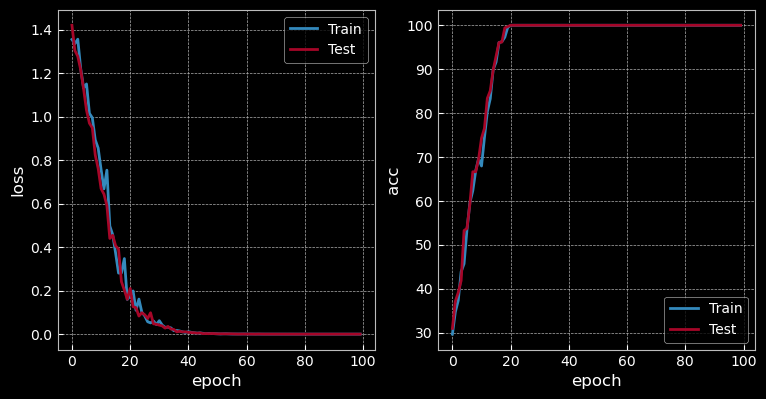

In [104]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.RMSprop()
max_epochs = 100

model = train_and_test(model, train_data_gen, test_data_gen, criterion,
                      optimizer, max_epochs)

## 8. Visualize LSTM
Setting difficulty to `MODERATE` and `hidden_size` to 12.

[Epoch 1/100] loss: 1.3864, acc: 23.39% - test_loss: 1.3885, test_acc: 25.40%
[Epoch 2/100] loss: 1.3820, acc: 23.29% - test_loss: 1.3859, test_acc: 24.70%
[Epoch 3/100] loss: 1.3808, acc: 25.10% - test_loss: 1.3912, test_acc: 26.01%
[Epoch 4/100] loss: 1.3820, acc: 25.60% - test_loss: 1.3880, test_acc: 26.81%
[Epoch 5/100] loss: 1.3803, acc: 26.61% - test_loss: 1.3802, test_acc: 28.93%
[Epoch 6/100] loss: 1.3243, acc: 36.90% - test_loss: 1.2398, test_acc: 38.21%
[Epoch 7/100] loss: 1.2288, acc: 53.23% - test_loss: 1.0301, test_acc: 57.06%
[Epoch 8/100] loss: 0.9302, acc: 53.02% - test_loss: 0.9506, test_acc: 57.56%
[Epoch 9/100] loss: 0.7704, acc: 65.62% - test_loss: 1.0629, test_acc: 66.03%
[Epoch 10/100] loss: 1.0696, acc: 69.25% - test_loss: 0.9834, test_acc: 71.77%
[Epoch 11/100] loss: 0.8557, acc: 72.88% - test_loss: 0.8960, test_acc: 77.12%
[Epoch 12/100] loss: 0.6644, acc: 75.20% - test_loss: 0.7216, test_acc: 79.03%
[Epoch 13/100] loss: 0.7101, acc: 76.31% - test_loss: 0.6639,

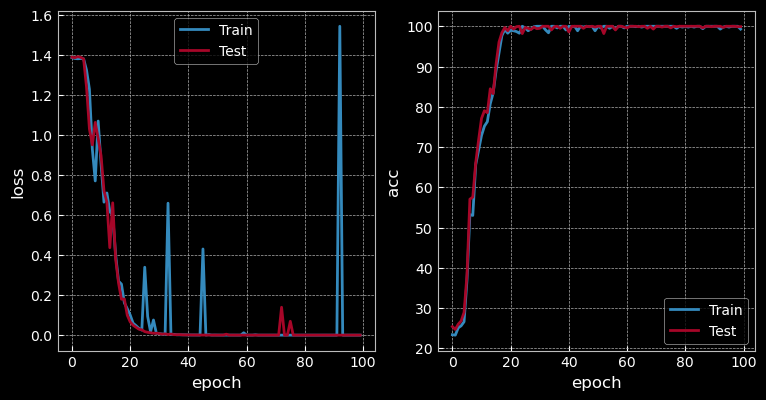

In [16]:
# For reproducibility
tf.random.set_seed(1)

# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 10
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer   = tf.keras.optimizers.RMSprop()
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, 
            test_data_gen, criterion, optimizer, max_epochs, verbose=True)

In [17]:
# Get hidden (H) and cell (C) batch state given a batch input (X)
data = test_data_gen[0][0]
X = tf.cast(data, dtype=tf.float32)
H_t, C_t = model.get_states_across_time(X)

In [18]:
print("Color range is as follows:")
print_colourbar()

Color range is as follows:


In [19]:
C_t = tf.transpose(C_t, (1, 0, 2)) # To use the same code's by DL Course

In [20]:
plot_state(X, C_t.numpy(), b=9, decoder=test_data_gen.decode_x)  # 3, 6, 9

In [21]:
plot_state(X, H_t.numpy(), b=9, decoder=test_data_gen.decode_x)